In [2]:
%matplotlib inline

In [13]:
#Import libraries
import os, fnmatch
import pickle
import simpleaudio as sa
from paramiko import SSHClient

from IPython.display import clear_output
from tqdm import tqdm   
from math import sqrt

from skimage.feature import blob_dog, blob_log

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import numpy as np
from numpy import interp

In [9]:
#Files directory
_datadir = "/nfs/NASPG/BTData/Jul2012_CMOS_data/MT9V011_Firenze_2012_07_13/TEST/"
#_datadir = "/nfs/NASPG/BTData/Jul2012_CMOS_data/MT9V011_Firenze_2012_07_13/16_MT9V011_017_G01_050ms_3MeV_-60/"

peds_value = np.zeros(307200,dtype="int")
peds_evts  = np.zeros(307200,dtype="int")
clusters   = []

In [10]:
#Calculate or (load) Pedestals
if not(os.path.isfile(_datadir+"pedestals.npy")):
    thresh = 200
    for _filename in tqdm(sorted(fnmatch.filter(os.listdir(_datadir), '*.txt'))):
        clear_output(wait=True)
        print("Processing "+_filename)
        im = np.loadtxt(_datadir+_filename,dtype="int")
        if im.shape == peds.shape:
            mask = im < thresh   # mask of pixels under threshold (good for pedestals)
            im[im >= thresh] = 0 # to prevent adding events with signal 
            peds_value += im
            peds_evts += mask.astype(int)
        else:
            continue
    peds_evts[peds_evts==0] = 1 #Mask pixels with 0 good events
    peds = peds_value/peds_evts
    peds.dump(_datadir+"pedestals.npy")
else:
    peds = np.load(_datadir+"pedestals.npy",allow_pickle="True")

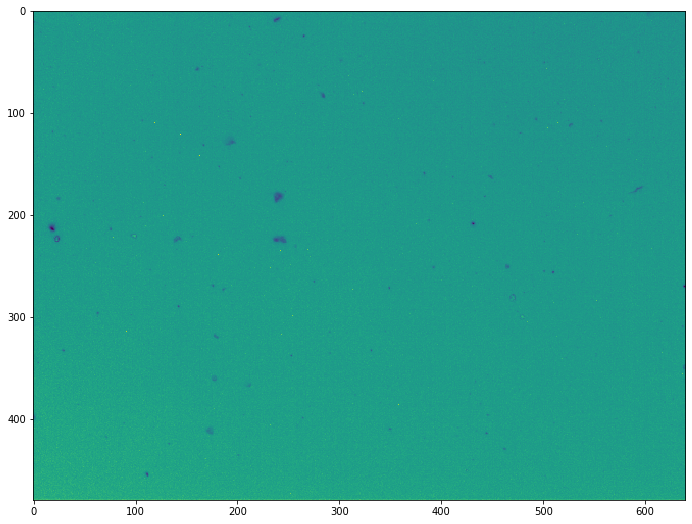

In [22]:
_filename = "01_MT9V011_017_G01_200ms_3MeV_00000_fr0000.txt"
frame = np.loadtxt(_datadir + _filename) - peds
frame = frame.reshape(480,640)
_temp = interp(frame,[0,1024],[0,1])
plt.figure(figsize=(16,9))
plt.imshow(_temp)

In [12]:
#Find clusters in every frame
for _filename in tqdm(sorted(fnmatch.filter(os.listdir(_datadir), '*.txt'))):
    clear_output(wait=True)
    print("Processing "+_filename)
    frame = np.loadtxt(_datadir+_filename,dtype="int")
    
    if frame.shape == peds.shape:
        frame = frame - peds
    else:
        continue
        
    frame = frame.reshape(480,640)
    _temp = interp(frame,[0,1024],[0,1])
    #Find "blobs"
    blobs_log = blob_log(_temp, max_sigma=100, num_sigma=50, threshold=.05)
    blobs_log[:, 2] = blobs_log[:, 2] * 2 * sqrt(2)
    #blobs_dog = blob_dog(im, max_sigma=50, threshold=.05)
    #blobs_dog[:, 2] = blobs_dog[:, 2] * 1.5 * sqrt(2)
    for _x, _y, _r in blobs_log:
        _min_y = (_y - _r).astype(int)
        _max_y = (_y + _r).astype(int)
        _min_x = (_x - _r).astype(int)
        _max_x = (_x + _r).astype(int)
        _subim = frame[_min_x:_max_x,_min_y:_max_y]
        clusters.append([np.max(_subim), np.sum(_subim), _subim.size])
        
with open(_datadir + "clusters.p", 'wb') as fp:
    pickle.dump(clusters, fp)
    
audio = 'tada.wav'
wave_obj = sa.WaveObject.from_wave_file(audio)
play_obj = wave_obj.play()
play_obj.wait_done()  # Wait until sound has finished playing

Processing 01_MT9V011_017_G01_200ms_3MeV_00002_fr0000.txt


100%|██████████| 3/3 [00:38<00:00, 12.74s/it]
